# Mapping Climatic and Seismic Data from the Stehekin Debris Flows

## Data Types:
- Seismic, request from IRIS
- Stream gauge data, request from USGS
- Precipitation data, request from NOAA

## Dependencies:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Initialize IRIS
- This API is programmatic, we can pull data directly through Python in VSCode
- We pick the UW PNSN network's DREAM station from Stehekin in the North Cascades, nearby the Stehekin debris flows
- We select data from Dec. 11, the day that the debris flows began
- See PNSN page for the station here: https://pnsn.org/station/dream

In [2]:
# Initialize IRIS client
client = Client("IRIS")

# Define time range - a few days before to a few days after the debris flows
#starttime = UTCDateTime("2025-12-10T13:00:00")
#endtime = UTCDateTime("2025-12-12T08:00:00")

starttime = UTCDateTime("2025-12-09T00:00:00")
endtime = UTCDateTime("2025-12-13T00:00:00")

starttime_2 = UTCDateTime("2025-12-13T00:00:00")
endtime_2 = UTCDateTime("2025-12-17T00:00:00")

# Pull data from Stehekin station
network = 'UW'
station = 'DREAM'

try:
    st = client.get_waveforms(network, station, "*", "*", starttime, endtime)
    print(f"Successfully retrieved data for {network}.{station}")

    st_2 = client.get_waveforms(network, station, "*", "*", starttime_2, endtime_2)
    print(f"Successfully retrieved data for {network}.{station} (second period)")
except Exception as e:
    print(f"Error retrieving data for {network}.{station}: {e}")

Successfully retrieved data for UW.DREAM
Successfully retrieved data for UW.DREAM (second period)


## Data Processing
We pick the three-components of the seismogram and then plot:

In [3]:
# Merge streams
st = st + st_2

# Merge traces with the same channel codes
st = st.merge(method=1, fill_value=0)
# Select specific channels using wildcards or multiple select calls
st_filtered = st.copy()
st = st_filtered.select(channel="ENZ") + st_filtered.select(channel="ENN") + st_filtered.select(channel="ENE")

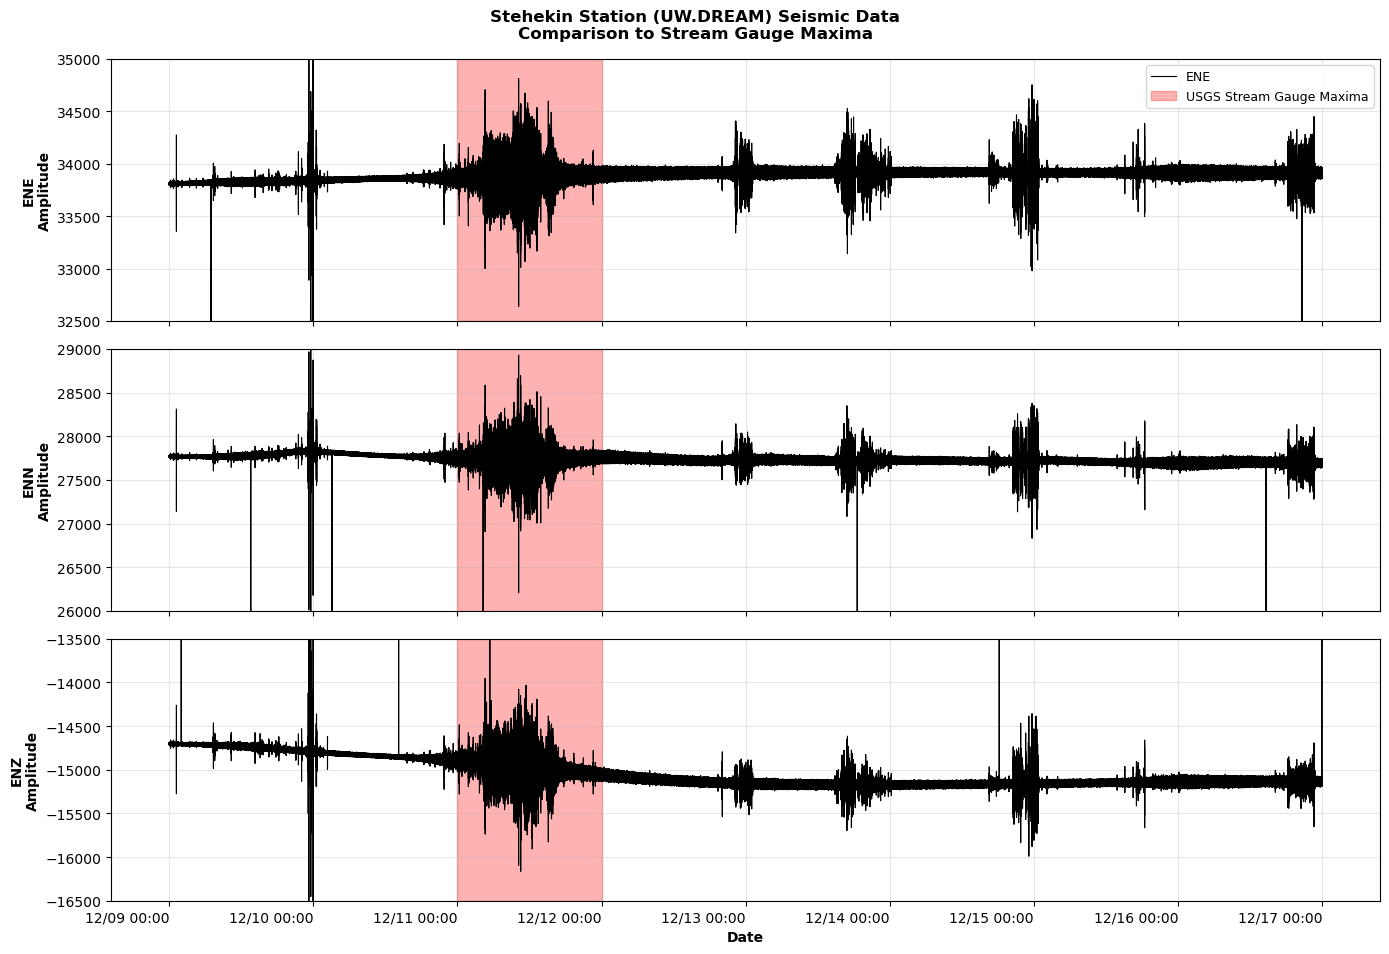

In [6]:
# Plot the components
num_traces = len(st)
fig, axes = plt.subplots(num_traces, 1, figsize=(14, 10), sharex=True)

# Plot each component
for i, tr in enumerate(st.sort(['channel'])):
    ax = axes[i]
    
    # Setup time axis
    time = tr.times()
    
    # Plot waveform
    ax.plot(time, tr.data, 'k', linewidth=0.8, label=tr.stats.channel)
    ax.set_ylabel(f"{tr.stats.channel}\nAmplitude", fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add red, vertical overlay for the whole of Dec 11, 2025, the day of stream gauge maxima
    gauge_maxima_start = UTCDateTime("2025-12-11T00:00:00")
    gauge_maxima_end = UTCDateTime("2025-12-12T00:00:00")
    gauge_seconds_start = gauge_maxima_start - starttime
    gauge_seconds_end = gauge_maxima_end - starttime
    ax.axvspan(gauge_seconds_start, gauge_seconds_end, color='red', alpha=0.3, label='USGS Stream Gauge Maxima' if i == 0 else "")

    # Add blue, vertical dashed line at NOAA precipitation maxima
    #precip_maxima = UTCDateTime("2025-12-11T06:00:00")
    #precip_seconds = precip_maxima - starttime
    #ax.axvline(precip_seconds, color='blue', linestyle='--', linewidth=2, label='NOAA Precipitation Maxima' if i == 0 else "")

    if i == 0:
        ax.legend(loc='upper right', fontsize=9)

axes[-1].set_xlabel('Date', fontweight='bold')

# Create datetime labels for x-ticks
tick_positions = np.arange(0, (endtime_2 - starttime) + 1, 86400)  # Every 24 hours in seconds
tick_datetimes = [(starttime + pos).datetime for pos in tick_positions]

axes[-1].set_xticks(tick_positions)
axes[-1].set_xticklabels([mdates.DateFormatter('%m/%d %H:%M')(mdates.date2num(dt)) for dt in tick_datetimes], ha='right')

axes[0].set_ylim(32500, 35000)
axes[1].set_ylim(26000, 29000)
axes[2].set_ylim(-16500, -13500)

# Title
title = (f"Stehekin Station ({network}.{station}) Seismic Data\n"
         f"Comparison to Stream Gauge Maxima")


fig.suptitle(title, fontsize=12, fontweight='bold', y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("stehekin_seismic.png", dpi=300)
plt.show()

print()